# Working with shapes

Shapes are object created using the package `Shapely` which know about their geometry. They don't need to be associated with a map in any way. We will start with basic shapes, and then use shapes on a map, since shape functions have been included in `cartopy`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import shapely.geometry
import shapely.ops
import cartopy
import cartopy.io.shapereader as shpreader

### 0D shapes: Points

In [2]:
point = shapely.geometry.Point(0.2, 1.0)

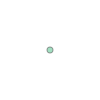

In [3]:
# Notice, the ipython '__repr__' (representation) displays the point as the output
point

In [4]:
# See some of the point attributes
print(point.geom_type)
print(point.area)
print(point.length)
print(point.bounds)
print(point.coords)   # explore this object...
print(point.coords[:])

Point
0.0
0.0
(0.2, 1.0, 0.2, 1.0)
[(0.2, 1.0)]


In [5]:
# A collection of random points...
point1 = shapely.geometry.Point(0.2, 1.0)
point2 = shapely.geometry.Point(0.1, 0.2)
point3 = shapely.geometry.Point(0.5, 0.0)
point4 = shapely.geometry.Point(0.8, 0.5)

In [6]:
# We can see the distance of the points from one another
point2.distance(point1)

0.806225774829855

### 1D shapes: Lines and Rings

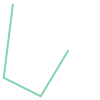

In [7]:
# An ordered sequence of points is a `LineString'
line = shapely.geometry.LineString((point1, point2, point3, point4))
line

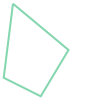

In [8]:
# To make a closed shape, use a `LinearRing'
closed_line = shapely.geometry.LinearRing(line)
closed_line

In [9]:
# Some of the attributes of the LinearRing..
print(closed_line.area)   # no area since it is not 'filled'
print(closed_line.length) # the perimeter of the shape
print(closed_line.bounds) # an xy-plane bounding box

0.0
2.6175595274050085
(0.1, 0.0, 0.8, 1.0)


### 2D shapes, Polygons and Buffers

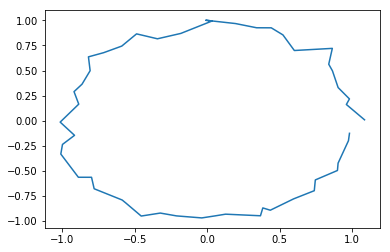

In [10]:
# Let's make a circle, with some noise

N = 50

x = np.cos(np.linspace(0, 2.0*np.pi, N+1))[:-1] + 0.05*np.random.randn(50)
y = np.sin(np.linspace(0, 2.0*np.pi, N+1))[:-1] + 0.05*np.random.randn(50)

plt.plot(x, y, '-')


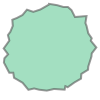

In [11]:
xy = zip(x, y)
poly = shapely.geometry.Polygon(xy)
poly

3.049230505197902
POINT (0.009403797381210289 -0.01334593767337028)
False True


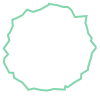

In [12]:
# Some of the Polygon attributes
print(poly.area)  # does this make sense?
print(poly.centroid)
print(poly.contains(point1), poly.contains(point2))
poly.boundary

We can also create 2D objects by adding buffers to existing 0D and 1D objects

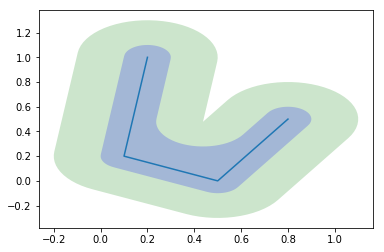

In [13]:
dialated = line.buffer(0.3)
eroded = dialated.buffer(-0.2)

plt.plot(*line.xy)
plt.fill(*dialated.boundary.xy, 'g', alpha=0.2)
plt.fill(*eroded.boundary.xy, 'b', alpha=0.2)

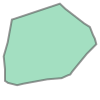

In [14]:
poly.buffer(-.8)

### Operations

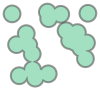

In [15]:
# First, let's make a collection of fat points.
xy = np.random.rand(20, 2)
points = shapely.geometry.MultiPoint(xy).buffer(0.1)
points

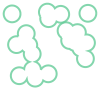

In [16]:
points.boundary

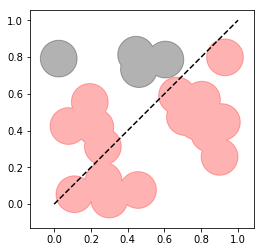

In [17]:
# make a new line
line2 = shapely.geometry.LineString([(0, 0), (1, 1)])

# loop over the polygons in the regions and plot, colored 
# differently if they intersect line1
for poly in points.boundary:
    if poly.intersects(line2):
        color = 'r'
    else:
        color = 'k'
    coords = poly.coords[:]
    x, y = zip(*coords)
    plt.fill(x, y, color=color, alpha=0.3)

# Plot the line also
x, y = zip(*line2.coords[:])
plt.plot(x, y, '--k')
plt.gca().set_aspect(1.0)